In [1]:
%matplotlib inline

Make sure you have the latest versions of bw2calc, presamples, bw2parameters, etc.!

In [2]:
import presamples
import brightway2 as bw
import matplotlib.pyplot as plt

In [3]:
bw.projects.set_current("Parameterized foreground GSA")

In [4]:
db = bw.Database("ecoinvent 3.4 cutoff")
assert len(db), "must install ecoinvent"
assert len(bw.Database("biosphere3")), "must run bw2setup"
assert len(bw.methods), "must run bw2setup"

In [4]:
e = bw.ExcelImporter("parameterized-foreground.xlsx")
e.apply_strategies()
e.match_database("ecoinvent 3.4 cutoff", fields=('name', 'location'))
e.match_database("ecoinvent 3.4 cutoff", fields=('name', 'location', 'reference product'))
e.match_database(fields=["name"])
e.statistics()

Extracted 1 worksheets in 0.01 seconds
Applying strategy: csv_restore_tuples
Applying strategy: csv_restore_booleans
Applying strategy: csv_numerize
Applying strategy: csv_drop_unknown
Applying strategy: csv_add_missing_exchanges_section
Applying strategy: normalize_units
Applying strategy: normalize_biosphere_categories
Applying strategy: normalize_biosphere_names
Applying strategy: strip_biosphere_exc_locations
Applying strategy: set_code_by_activity_hash
Applying strategy: link_iterable_by_fields
Applying strategy: assign_only_product_as_production
Applying strategy: link_technosphere_by_activity_hash
Applying strategy: drop_falsey_uncertainty_fields_but_keep_zeros
Applying strategy: convert_uncertainty_types_to_integers
Applied 15 strategies in 0.26 seconds
Applying strategy: link_iterable_by_fields
Couldn't apply strategy link_iterable_by_fields:
	Object in source database can't be uniquely linked to target database.
Problematic dataset is:
{'filename': '(missing)', 'location': 'R

(3, 7, 0)

In [5]:
e.write_database()

Writing activities to SQLite3 database:
0%  100%
[###] | ETA: 00:00:00
Total time elapsed: 00:00:00


Title: Writing activities to SQLite3 database:
  Started: 05/11/2018 18:02:03
  Finished: 05/11/2018 18:02:03
  Total time elapsed: 00:00:00
  CPU %: 111.00
  Memory %: 0.58
Created database: Weekend break


In [6]:
from presamples.models import ParameterizedBrightwayModel

In [7]:
model = ParameterizedBrightwayModel("weekend_trip_gsa")           # Name of parameter group
model.load_parameter_data()                                       # Load data from parameters database
model.calculate_stochastic(iterations=1000, update_amounts=True)  # 1000 Monte Carlo iterations; keep results
model.calculate_matrix_presamples()                               # Transform results to be useful in LCA calculations
_, filepath = model.save_presample("gsa_example") 

In [8]:
filepath

PosixPath('/Users/cmutel/Library/Application Support/Brightway3/Parameterized-foreground-GSA.1ce37c4de59056c11cd7b47e75414782/presamples/e57561335f1647d4bb0d3d9c27a73e37')

In [4]:
filepath = '/Users/cmutel/Library/Application Support/Brightway3/Parameterized-foreground-GSA.1ce37c4de59056c11cd7b47e75414782/presamples/e57561335f1647d4bb0d3d9c27a73e37'

(array([6., 1., 0., 1., 3., 0., 6., 1., 1., 1.]),
 array([ 4.70717409,  9.70736654, 14.707559  , 19.70775146, 24.70794391,
        29.70813637, 34.70832883, 39.70852129, 44.70871374, 49.7089062 ,
        54.70909866]),
 <a list of 1 Patch objects>)

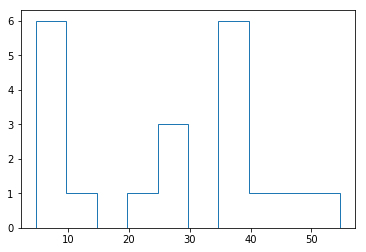

In [11]:
mc = bw.MonteCarloLCA({("Weekend break", "break"): 1}, ('ReCiPe Endpoint (E,A)', 'total', 'total'), presamples=[filepath])

results = []

for _ in range(20):
    next(mc)
    # print(mc.score, mc.presamples.parameters[0]['weekend_trip_gsa__transport_mode'] > 0.5)
    results.append(mc.score)

plt.hist(results, histtype="step")

In [9]:
list(mc.presamples.parameters[0].items())

[('weekend_trip_gsa__food_consumed', 1.0),
 ('weekend_trip_gsa__hungry', 0.8683699151910227),
 ('weekend_trip_gsa__transport_mode', 0.05596176194411029),
 ('weekend_trip_gsa__vegetarian', 0.8600932648197973)]

# Global Sensitivity Analysis

We use the technique of [Plischke et al 2013](http://www.sciencedirect.com/science/article/pii/S0377221712008995) as implemented in [SALib](http://joss.theoj.org/papers/431262803744581c1d4b6a95892d3343). We adapt [this code](https://github.com/SALib/SALib/blob/master/SALib/analyze/delta.py) for our input data structure.

In [ ]:
def analyze(X, Y, num_resamples=10, conf_level=0.95):
    """Perform Delta Moment-Independent Analysis on model outputs.
    
    Returns a dictionary with keys 'delta', 'delta_conf', 'S1', and 'S1_conf',
    where each entry is a list of size D (the number of parameters) containing
    the indices in the same order as the parameter file.
    
    Parameters
    ----------
    X: A NumPy array containing the model inputs. Parameters are columns, samples are rows.
    Y : A NumPy array containing the model outputs
    num_resamples : int
        The number of bootstrap resamples when computing confidence intervals (default 10)
    conf_level : float
        The confidence interval level (default 0.95)
        
    References
    ----------
    .. [1] Borgonovo, E. (2007). "A new uncertainty importance measure."
           Reliability Engineering & System Safety, 92(6):771-784,
           doi:10.1016/j.ress.2006.04.015.
           
    .. [2] Plischke, E., E. Borgonovo, and C. L. Smith (2013). "Global
           sensitivity measures from given data." European Journal of
           Operational Research, 226(3):536-550, doi:10.1016/j.ejor.2012.11.047.
           
    """

    D = X.shape[1]
    N = Y.size

    if not 0 < conf_level < 1:
        raise RuntimeError("Confidence level must be between 0-1.")

    # equal frequency partition
    M = min(np.ceil(N ** (2 / (7 + np.tanh((1500 - N) / 500)))), 48)
    m = np.linspace(0, N, M + 1)
    Ygrid = np.linspace(np.min(Y), np.max(Y), 100)

    keys = ('delta', 'delta_conf', 'S1', 'S1_conf')
    S = dict((k, np.zeros(D)) for k in keys)

    for i in range(D):
        S['delta'][i], S['delta_conf'][i] = bias_reduced_delta(
            Y, Ygrid, X[:, i], m, num_resamples, conf_level)
        S['S1'][i] = sobol_first(Y, X[:, i], m)
        S['S1_conf'][i] = sobol_first_conf(
            Y, X[:, i], m, num_resamples, conf_level)

    return S

# Plischke et al. 2013 estimator (eqn 26) for d_hat

def calc_delta(Y, Ygrid, X, m):
    N = len(Y)
    fy = gaussian_kde(Y, bw_method='silverman')(Ygrid)
    xr = rankdata(X, method='ordinal')

    d_hat = 0
    for j in range(len(m) - 1):
        ix = np.where((xr > m[j]) & (xr <= m[j + 1]))[0]
        nm = len(ix)
        fyc = gaussian_kde(Y[ix], bw_method='silverman')(Ygrid)
        d_hat += (nm / (2 * N)) * np.trapz(np.abs(fy - fyc), Ygrid)

    return d_hat

# Plischke et al. 2013 bias reduction technique (eqn 30)

def bias_reduced_delta(Y, Ygrid, X, m, num_resamples, conf_level):
    d = np.zeros(num_resamples)
    d_hat = calc_delta(Y, Ygrid, X, m)

    for i in range(num_resamples):
        r = np.random.randint(len(Y), size=len(Y))
        d[i] = calc_delta(Y[r], Ygrid, X[r], m)

    d = 2 * d_hat - d
    return (d.mean(), norm.ppf(0.5 + conf_level / 2) * d.std(ddof=1))


def sobol_first(Y, X, m):
    xr = rankdata(X, method='ordinal')
    Vi = 0
    N = len(Y)
    for j in range(len(m) - 1):
        ix = np.where((xr > m[j]) & (xr <= m[j + 1]))[0]
        nm = len(ix)
        Vi += (nm / N) * (Y[ix].mean() - Y.mean()) ** 2
    return Vi / np.var(Y)


def sobol_first_conf(Y, X, m, num_resamples, conf_level):
    s = np.zeros(num_resamples)

    for i in range(num_resamples):
        r = np.random.randint(len(Y), size=len(Y))
        s[i] = sobol_first(Y[r], X[r], m)

    return norm.ppf(0.5 + conf_level / 2) * s.std(ddof=1)

In [ ]:
results = {}

for method in pyprind.prog_bar(('CED', 'GWP', 'HTP', 'MDP', 'PMFP', 'POFP')):
    output = analyze(inputs_as_array, data[method].as_matrix())
    # Doesn't sum to one because of bias reduction
    total = output['delta'].sum()
    labelled = sorted([(x / total, y) for y, x in zip(independent_params, output['delta'])], reverse=True)
    labelled = [(x, y, z) for (x, z), y in zip(labelled, np.cumsum([x[0] for x in labelled]))]
    results[method] = pd.DataFrame(labelled, columns=['Sensitivity', 'Cumulative', 'Label'])